# Dangerous driver detection

In this exercise, we will classify images of drivers and decide if they exhibit any of one of nine dangerous behaviours, or whether they are deemed to drive safely.

## Setup

In [1]:
%matplotlib inline

Set the path to input data. Change this to run on some other box.

In [2]:
inputdir = '/home/ubuntu/data/state-farm'
model_path = "http://files.fast.ai/models/"

A bunch of generic imports.

In [3]:
import os
import numpy as np
np.set_printoptions(precision=4, linewidth=100)

Load (and reload) the utility code we use in later steps.

In [4]:
from imp import reload
import utils; reload(utils)

<module 'utils' from 'utils.pyc'>

Keras setup

In [5]:
from numpy.random import random, permutation

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.preprocessing import image

# SPECIAL GLOBAL MAGIC SETTING THAT IF WE DON'T SET IT MAKES THINGS BLOW UP!!!  :-/
K.set_image_dim_ordering('th')

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Model creation

We'll try building a Vgg16 model and fine tune it, to see how far that gets us.

In [7]:
def add_conv_block(model, layers, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

def add_fully_connected_block(model):
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))

# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

def vgg16_model():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape = (3, 224, 224)))
    
    add_conv_block(model, 2, 64)
    add_conv_block(model, 2, 128)
    add_conv_block(model, 3, 256)
    add_conv_block(model, 3, 512)
    add_conv_block(model, 3, 512)

    model.add(Flatten())
    add_fully_connected_block(model)
    add_fully_connected_block(model)
    model.add(Dense(1000, activation='softmax'))
    return model

Create a model and load weights into it.

In [9]:
model = vgg16_model()
fpath = get_file('vgg16.h5', model_path + 'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Input data

Get the driver images as provided by Kaggle.

In [30]:
batch_size = 64

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=False, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(inputdir + '/' + dirname, target_size=(224, 224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [31]:
training_batches = get_batches('train', batch_size=batch_size, shuffle=True)
validation_batches = get_batches('valid', batch_size=batch_size)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


Let's have a look at some of the data:

Found 17943 images belonging to 10 classes.


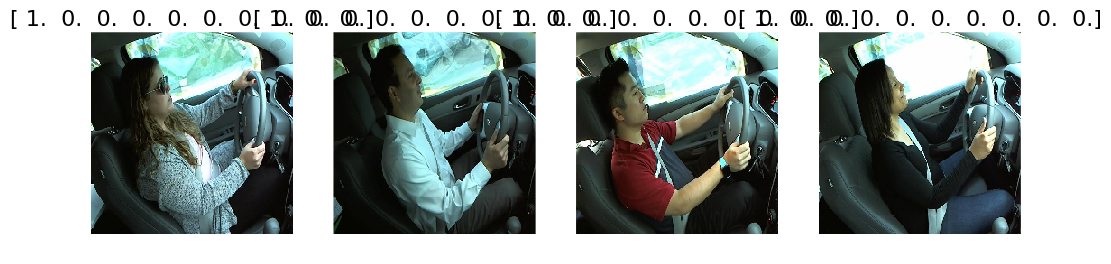

In [18]:
sample_batches = get_batches('train', batch_size=batch_size)
imgs, labels = next(sample_batches)
utils.plot_images(imgs[:4], titles=labels[:4])

Try fine tuning the Vgg16 model and classify with this.

## Fine tuning the model

In [19]:
model.pop() # I hate these mutating operations. Running this cell a second time will completely screw up the network!

In [20]:
for layer in model.layers: layer.trainable=False

In [21]:
model.add(Dense(10, activation='softmax'))

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [23]:
model.compile(optimizer=Adam(lr=0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])

Get class labels.

In [24]:
# We get class labels and indexes from the batches we read earlier
indexes_to_classes = dict((v,k) for k,v in training_batches.class_indices.items())
in_index_order = dict(sorted(indexes_to_classes.items()))
# Get the classes in order of their index values
classes = list(in_index_order.values())
print("Class labels: ", classes)

('Class labels: ', ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])


## Training the model

In [25]:
training_history = model.fit_generator(training_batches, samples_per_epoch=training_batches.nb_sample, nb_epoch=1,
                       validation_data=validation_batches, nb_val_samples=validation_batches.nb_sample)

Epoch 1/1
17943/17943 [==============================] - 568s - loss: 1.9978 - acc: 0.4472 - val_loss: 0.5563 - val_acc: 0.8302


In [26]:
model.fit_generator(training_batches, samples_per_epoch=training_batches.nb_sample, nb_epoch=3,
                       validation_data=validation_batches, nb_val_samples=validation_batches.nb_sample)

Epoch 1/3
17943/17943 [==============================] - 565s - loss: 1.1022 - acc: 0.6478 - val_loss: 0.3836 - val_acc: 0.8969
Epoch 2/3
17943/17943 [==============================] - 559s - loss: 0.9557 - acc: 0.6924 - val_loss: 0.3276 - val_acc: 0.9139
Epoch 3/3
17943/17943 [==============================] - 563s - loss: 0.9042 - acc: 0.7119 - val_loss: 0.2814 - val_acc: 0.9277


In [27]:
model.save_weights('fitted_weights_finetune-1-layer_4-epochs.h5')

In [ ]:
model.fit_generator(training_batches, samples_per_epoch=training_batches.nb_sample, nb_epoch=3,
                       validation_data=validation_batches, nb_val_samples=validation_batches.nb_sample)
model.save_weights('fitted_weights_finetune-1-layer_7-epochs.h5')

Epoch 1/3
   64/17943 [..............................] - ETA: 718s - loss: 1.0168 - acc: 0.7500

## Classify test images

Load some sample images and classify them so we can see if the scores look OK for these.

In [37]:
batch_size = 50
sample_test_batches = get_batches('test', batch_size=batch_size, class_mode=None, shuffle=True)
images = next(sample_test_batches)

Found 79726 images belonging to 1 classes.


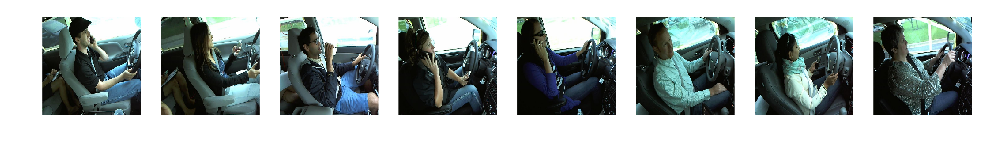

In [38]:
utils.plot_images(images[:8], titles=None)

In [39]:
predictions = model.predict(images)
print(predictions[:8])

[[  2.0603e-02   7.0299e-03   1.2481e-02   5.2426e-02   6.8162e-01   7.1979e-02   5.6115e-02
    7.7832e-03   8.6052e-02   3.9121e-03]
 [  2.1770e-01   1.8736e-04   4.2667e-02   5.9802e-01   3.9485e-02   5.4905e-03   3.5541e-03
    2.1585e-02   5.4228e-02   1.7077e-02]
 [  5.2829e-02   5.8991e-02   6.0963e-03   2.5864e-02   8.4471e-03   2.1098e-01   1.2030e-01
    1.8720e-02   2.3991e-01   2.5785e-01]
 [  2.8478e-02   3.5494e-03   4.1047e-01   3.6550e-03   9.3584e-02   2.3131e-03   3.4508e-02
    1.5432e-03   6.5559e-02   3.5634e-01]
 [  4.4674e-03   4.7721e-04   8.5814e-01   1.5480e-04   3.1980e-03   5.7596e-05   4.0710e-02
    1.1834e-02   3.6741e-02   4.4218e-02]
 [  8.6870e-03   1.2874e-03   1.6955e-04   3.4569e-04   1.5139e-03   4.5155e-01   1.0324e-03
    1.5109e-02   6.5101e-02   4.5520e-01]
 [  5.3676e-01   3.2865e-02   3.7944e-03   1.7659e-01   5.5779e-02   2.5824e-03   1.3026e-01
    3.7624e-03   4.2662e-03   5.3340e-02]
 [  6.9539e-03   4.9355e-04   5.6760e-06   9.9094e-01  

Now run this on the full test set.

In [ ]:
test_batches = get_batches('test', batch_size=batch_size, shuffle=False, class_mode=None)
all_test_predictions = model.predict_generator(test_batches, test_batches.nb_sample)

Found 79726 images belonging to 1 classes.


In [42]:
print(all_test_predictions[:8])
max_score_idxs = np.argmax(all_test_predictions, axis=1)
print(max_score_idxs[:8])
print(test_batches.filenames[:8], len(test_batches.filenames))
max_score_idxs

[[  5.7294e-02   3.2302e-03   6.3892e-04   4.2571e-03   2.9412e-03   7.3164e-02   2.5018e-01
    5.9148e-03   3.4088e-02   5.6829e-01]
 [  2.5155e-01   7.8934e-03   4.9101e-05   3.4421e-02   1.4831e-03   1.1172e-02   1.9210e-02
    1.4137e-01   5.1181e-01   2.1035e-02]
 [  9.2046e-04   5.8486e-05   1.0135e-01   2.2384e-01   2.0914e-01   1.1959e-03   1.6802e-01
    2.0087e-05   2.9415e-01   1.3085e-03]
 [  1.9294e-05   1.0386e-04   5.2125e-01   4.0633e-04   2.3438e-03   7.5209e-05   1.7782e-02
    4.2872e-03   4.5226e-01   1.4696e-03]
 [  1.3083e-02   1.1415e-02   4.0423e-02   2.2155e-03   7.6129e-04   1.7074e-02   6.3912e-01
    7.3050e-03   2.2422e-01   4.4384e-02]
 [  2.8691e-05   1.9941e-03   1.0564e-03   2.9201e-02   1.6585e-03   5.9426e-04   1.2866e-02
    9.4116e-01   1.1348e-02   9.0857e-05]
 [  6.1385e-02   7.1689e-03   1.3178e-02   3.4104e-02   9.0452e-03   1.7657e-02   2.9885e-02
    6.7664e-01   3.2027e-02   1.1891e-01]
 [  1.1457e-05   1.0099e-04   6.3226e-01   8.2971e-07  

array([9, 8, 8, ..., 5, 0, 0])

In [47]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [50]:
initial_probabilities = onehot(max_score_idxs)
initial_probabilities[:4]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [56]:
import pathlib
filenames = list(map((lambda fn: pathlib.Path(fn).name), test_batches.filenames))
file_ids = np.array(filenames)[:test_batches.nb_sample]
clipped_probs = np.clip(initial_probabilities, 0.05, 0.95)
results = np.column_stack([file_ids, clipped_probs])
print(results[:8])

[['img_81601.jpg' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.95']
 ['img_14887.jpg' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.95' '0.05']
 ['img_62885.jpg' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.95' '0.05']
 ['img_45125.jpg' '0.05' '0.05' '0.95' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05']
 ['img_22633.jpg' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.95' '0.05' '0.05' '0.05']
 ['img_45660.jpg' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.95' '0.05' '0.05']
 ['img_88962.jpg' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.95' '0.05' '0.05']
 ['img_92987.jpg' '0.05' '0.05' '0.95' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05' '0.05']]


Now write out the results as a CSV file with the desired column headers.

In [57]:
submission_filename = 'state-farm-1.csv'
np.savetxt(submission_filename, results, fmt='%s', delimiter=',', header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments = '')

And a handy link to the generated file.

In [58]:
from IPython.display import FileLink
FileLink(submission_filename)

/home/ubuntu/fast-ai-course/notebooks/deeplearning1/state-farm-1.csv